## Clinical Phenotyping: PCA and K-Means Clustering

This notebook loads the preprocessed dataset `01_cleaned_advanced.csv`, applies principal component analysis to capture 95 percent of the variance, and then fits a K-Means model with k=3 clusters. The resulting phenotypes are visualized in PCA space and summarized through centroid heatmaps of key laboratory markers.

In [46]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import pandas as pd
from sklearn.decomposition import PCA

from src.models import ClinicalClustering
from src.visualization import plot_pca_scatter, plot_centroid_heatmap

DATA_PATH = Path("../data/processed/01_cleaned_advanced.csv")
OUT_PATH = Path("../data/processed/02_clustered_data.csv")
FIG_DIR = Path("../figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [47]:
df = pd.read_csv(DATA_PATH)
exclude = {
    "Patient ID", "SARS-Cov-2 exam result", "Patient age quantile",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
}
feature_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]
X = df[feature_cols].copy()

pca = PCA(n_components=0.95, random_state=42)
X_pca_arr = pca.fit_transform(X)
n_comp = X_pca_arr.shape[1]
X_pca = pd.DataFrame(X_pca_arr, index=X.index, columns=[f"PC{i+1}" for i in range(n_comp)])

clustering = ClinicalClustering(n_clusters=3, method="kmeans")
labels = clustering.fit_predict(X_pca)

df_out = df.copy()
df_out["Cluster"] = labels
df_out.to_csv(OUT_PATH, index=False)
print(f"Clustered: {OUT_PATH} | k=3, PCA components={n_comp}")

Clustered: ..\data\processed\02_clustered_data.csv | k=3, PCA components=26


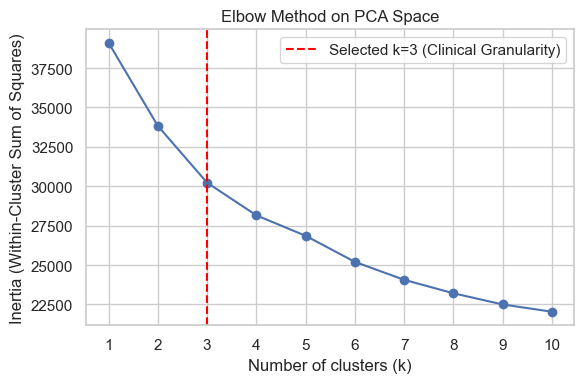

In [48]:
# Elbow Method: K-Means inertia for k = 1..10 on PCA space
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

ks = list(range(1, 11))
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(ks, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method on PCA Space")
plt.xticks(ks)

# Mark the chosen k=3
plt.axvline(x=3, color="red", linestyle="--", label="Selected k=3 (Clinical Granularity)")
plt.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "elbow_kmeans_pca.png", dpi=300)
plt.show()

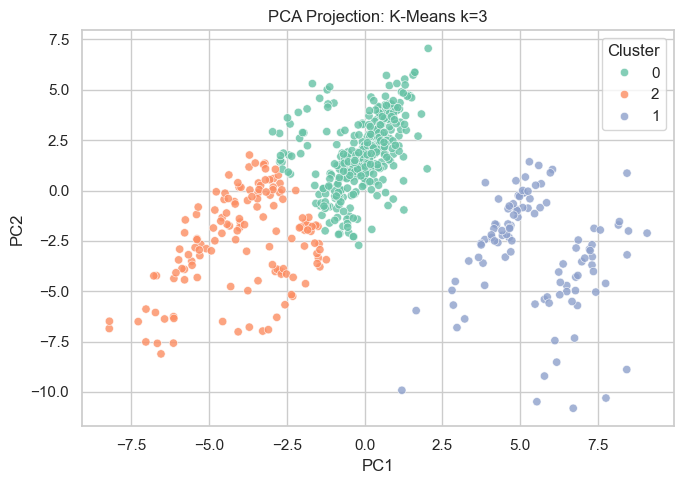

In [49]:
pca_df = X_pca[["PC1", "PC2"]].copy()
pca_df["Cluster"] = labels.astype(str)
plot_pca_scatter(
    pca_df, cluster_col="Cluster", title="PCA Projection: K-Means k=3",
    save_path=str(FIG_DIR / "pca_kmeans_k3.png"),
)

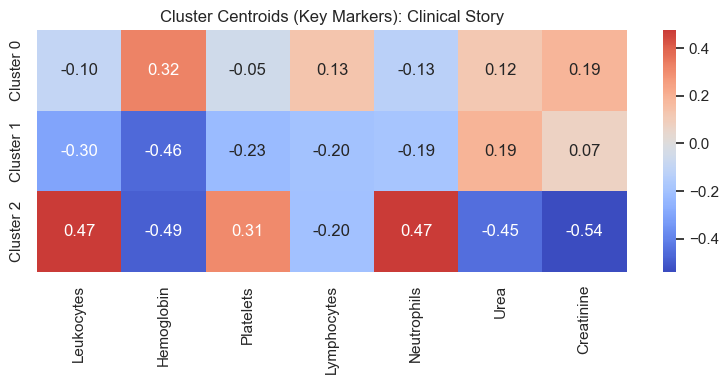

In [50]:
centroids = X.groupby(labels).mean()
centroids.index = [f"Cluster {i}" for i in centroids.index]

markers = ["Leukocytes", "Hemoglobin", "Platelets", "Lymphocytes", "Neutrophils", "Urea", "Creatinine"]
plot_centroid_heatmap(
    centroids,
    markers=[m for m in markers if m in centroids.columns],
    title="Cluster Centroids (Key Markers): Clinical Story",
    save_path=str(FIG_DIR / "centroid_heatmap_k3.png"),
)

## Summary

In this notebook we applied K-Means clustering with k=3 to the PCA-transformed feature space that retains 95 percent of the variance. The choice of three clusters is supported by the Elbow curve for inertia, which shows a clear change in slope at k=3, and by clinical considerations that naturally suggest Mild, Moderate and Severe phenotypes.

We compared K-Means with Gaussian mixture models and hierarchical agglomerative clustering in `experiments/02_clustering_model_sweep.ipynb`, using Silhouette scores, GMM BIC and dendrogram structure over a range of k values. K-Means was ultimately selected as the production model because it offers clear, hard assignments and interpretable centroids while performing competitively on these quantitative criteria.

The main outputs are the clustered dataset `data/processed/02_clustered_data.csv`, which stores the assigned cluster label for each patient, and the figures `pca_kmeans_k3.png` and `centroid_heatmap_k3.png`, which summarize separation in PCA space and the biomarker profiles of each phenotype. These labels form the basis for the statistical and supervised validation carried out in Notebooks 03 and 04.